In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('./sales_data.csv')

In [4]:
df.drop(columns='Company').head()

,Date,Type of Client,Type of Location,Location,Rating,Amount,Salesman
0,01-04-2024,Dealer,Industrial Complex,Sahibabad,1250 kVA,981288.0,A
1,04-04-2024,Regular,Industrial Complex,Faridabad,380 kVA,430700.0,B
2,06-04-2024,Dealer,Corporate Office,Gurgaon,380 kVA,340000.0,A
3,06-04-2024,Dealer,Corporate Office,Gurgaon,125 kVA,244100.0,A
4,08-04-2024,Regular,Residential,Greater Noida,320 kVA,472708.0,C


In [5]:
print(df.columns)

Index(['Date', 'Company', 'Type of Client', 'Type of Location', 'Location',
       'Rating', 'Amount', 'Salesman'],
      dtype='object')


# Feature Engineering

In [6]:
df['Type of Client'] = df['Type of Client'].astype('category')
df['Type of Location'] = df['Type of Location'].astype('category')
df['Salesman'] = df['Salesman'].astype('category')
df['Company'] = df['Company'].astype('category')
df['Location'] = df['Location'].astype(str).str.strip().str.title()
df['Location'] = df['Location'].astype('category')
df['Rating'] = df['Rating'].astype('category')
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
df['Month'] = df['Date'].dt.month

In [7]:
#Parse date and extract time-related features
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

#Extract numeric kVA rating from 'Rating' column
df['Rating_kVA'] = df['Rating'].str.extract(r'(\d+\.?\d*)').astype(float)

#Create feature for amount per kVA
df['Amount_per_kVA'] = df['Amount'] / df['Rating_kVA']

#Identify dealer clients
df['Is_Dealer'] = (df['Type of Client'] == 'Dealer').astype(int)

#Flag end-of-quarter sales
df['Is_Quarter_End'] = df['Month'].isin([3, 6, 9, 12]).astype(int)

#Compute location-based sales performance
location_avg = df.groupby('Location')['Amount'].transform('mean')
df['Location_Amount_Ratio'] = df['Amount'] / location_avg

#Add average sale amount for each Rating
rating_avg = df.groupby('Rating')['Amount'].mean()
df['Rating_Avg_Amount'] = df['Rating'].map(rating_avg)

#Mark sales as successful if amount >= 90% of median for that rating
rating_median = df.groupby('Rating')['Amount'].transform('median')
df['Success'] = (df['Amount'] >= 1 * rating_median).astype(int)


### Summary

This section performs data transformations to prepare the dataset for analysis and modeling. Each step focuses on extracting meaningful information that may help explain or predict sales performance:

- **Date Parsing and Extraction**: The `Date` column is converted into datetime format, and new columns for `Month` and `Year` are created to enable time-based analysis.

- **kVA Extraction**: Ratings provided as text are cleaned to extract numerical values (e.g., '500 kVA' → 500.0), allowing for meaningful numerical comparisons.

- **Amount per kVA**: A normalized sales value is calculated by dividing total sale amount by the rating in kVA, helping compare sales across different generator sizes.

- **Dealer Flag**: A binary column identifies whether the client is a dealer, as dealer purchases may behave differently from regular or institutional clients.

- **Quarter-End Indicator**: Sales occurring in March, June, September, and December are flagged, assuming quarter-end pressures might affect performance or volume.

- **Location Amount Ratio**: Each sale's amount is compared against the average sales for its location. This gives a relative measure of how well a particular sale performed in its regional context.

- **Rating-Wise Average Amount**: The average sales amount for each rating is added, which can be useful for benchmarking or modeling.

- **Success Definition**: Success is defined as any sale whose amount is at least 90% of the median for its rating. This balances outliers and includes slightly undervalued but still significant sales, offering a more realistic and business-aligned definition of success.


# Data Visualisation

### 1. Distribution Overview via Pie Charts

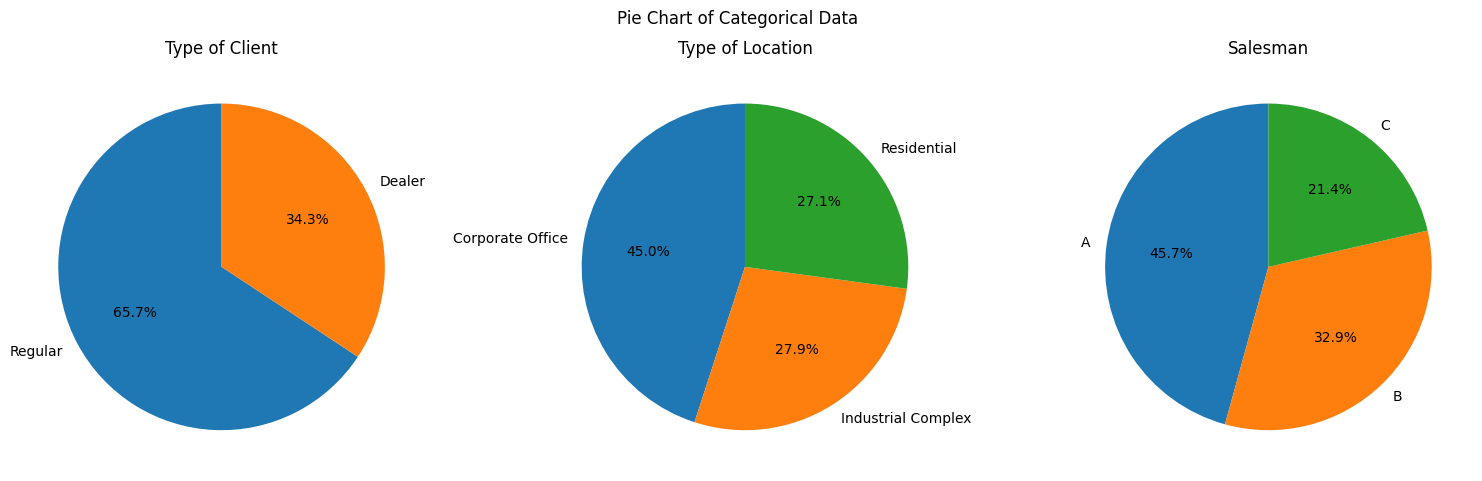

In [8]:
#Pie Chart for Categorical Data
client_type_count = df['Type of Client'].value_counts()
location_type_count = df['Type of Location'].value_counts()
salesman_count = df['Salesman'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].pie(client_type_count, labels=client_type_count.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Type of Client')

axs[1].pie(location_type_count, labels=location_type_count.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Type of Location')

axs[2].pie(salesman_count, labels=salesman_count.index, autopct='%1.1f%%',startangle=90)
axs[2].set_title('Salesman')

fig.suptitle('Pie Chart of Categorical Data')
plt.tight_layout()
plt.show()

#### Type of Client
This chart shows the proportion of clients categorized as either **Regular** or **Dealer**.  
- **Regular clients** make up a larger share, indicating most sales are made directly to end customers.  
- **Dealers**, who purchase on behalf of their own clients, form a smaller but significant segment.

#### Type of Location
The pie chart represents sales distribution across three location types:
- **Residential**: Apartment buildings or gated communities requiring backup power.
- **Corporate Offices**: Commercial buildings and offices that rely on uninterrupted power.
- **Industrial Complexes**: Factories or production units with higher capacity needs.

This breakdown helps understand where the bulk of generator demand is concentrated geographically and functionally.

#### Salesman Distribution
Sales are handled by three primary salesmen, labeled **A**, **B**, and **C**.  
- **Salesman A** is the most senior and likely handles high-profile or complex sales.  
- **Salesman B** is mid-level in experience.  
- **Salesman C** is relatively new but may focus on volume or smaller accounts.

The pie chart visually compares how responsibilities or successful client engagements are divided among the team.

### 2. Monthly Distribution of Amount

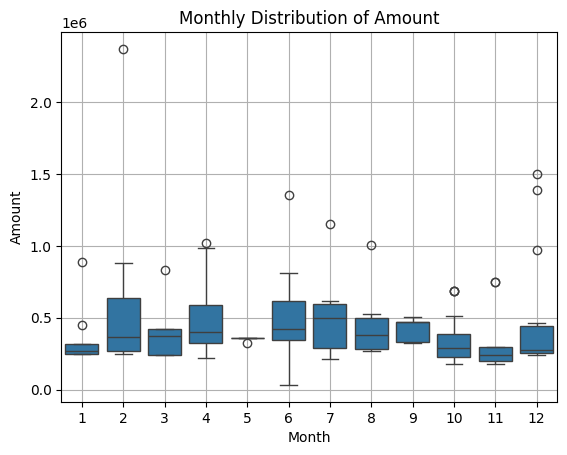

In [9]:
sns.boxplot(x=df['Month'], y=df['Amount'], data=df)
plt.title('Monthly Distribution of Amount')
plt.ylabel('Amount')
plt.xlabel('Month')
plt.grid(True)
plt.show()

This boxplot illustrates the spread of sales amounts across each month. Some months such as March and May display higher variability in sales values, while others show more consistent patterns. There are a few noticeable outliers across the year. This suggests that while sales volume may remain steady, the value of individual sales can fluctuate greatly, potentially due to the type of clients or gensets sold in those months.

### 3. Average Sale by Salesman, Location Type and Client Type

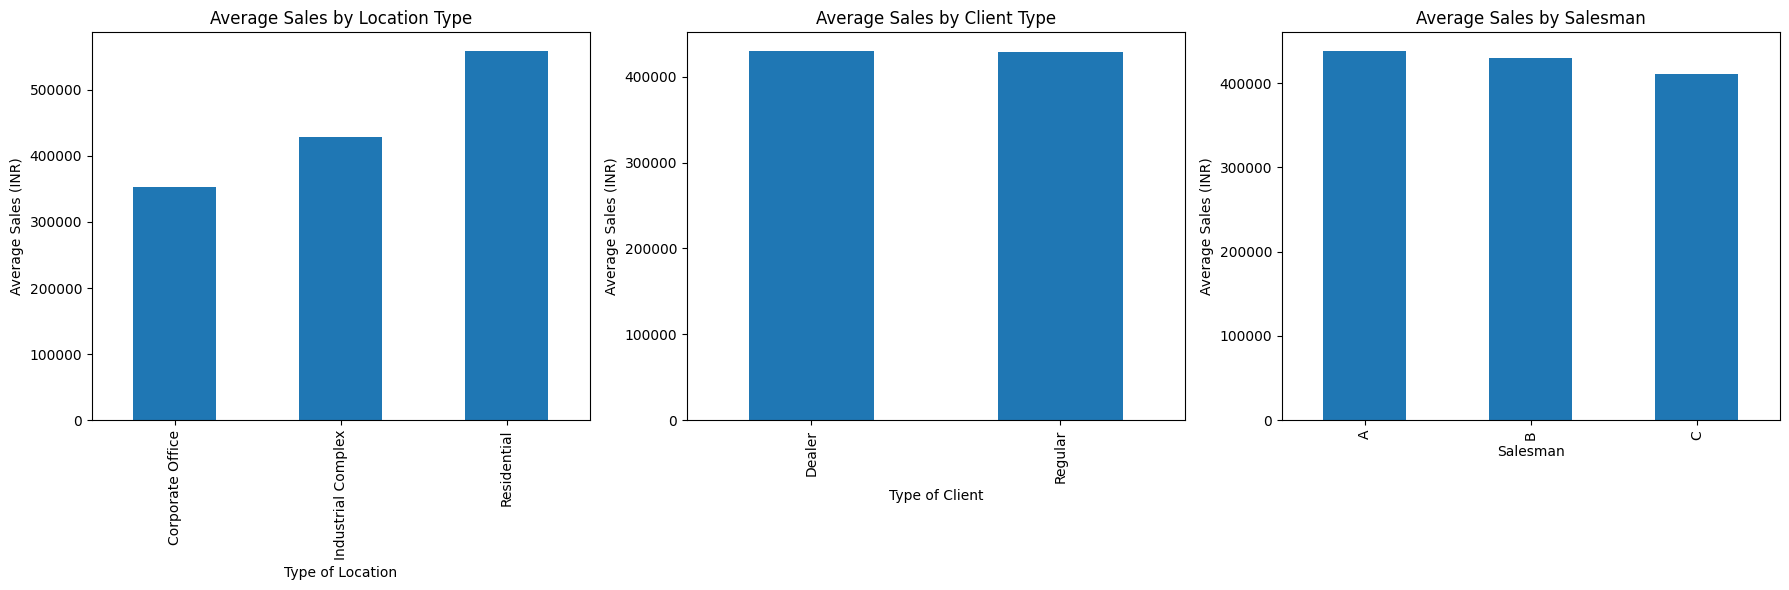

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Average Sales by Location Type
df.groupby('Type of Location')['Amount'].mean().plot(
    kind='bar', ax=axes[0], title='Average Sales by Location Type'
)
axes[0].set_xlabel('Type of Location')
axes[0].set_ylabel('Average Sales (INR)')

#Average Sales by Client Type
df.groupby('Type of Client')['Amount'].mean().plot(
    kind='bar', ax=axes[1], title='Average Sales by Client Type'
)
axes[1].set_xlabel('Type of Client')
axes[1].set_ylabel('Average Sales (INR)')

#Average Sales by Salesman
df.groupby('Salesman')['Amount'].mean().plot(
    kind='bar', ax=axes[2], title='Average Sales by Salesman'
)
axes[2].set_xlabel('Salesman')
axes[2].set_ylabel('Average Sales (INR)')

plt.tight_layout()
plt.show()

#### Average Sales by Location Type
Among the location types, residential areas appear to have the highest average sales amount. This might indicate larger or more frequent orders in residential settings, possibly due to higher backup power requirements or increased interest from individual buyers. Corporate offices and industrial complexes have slightly lower averages, which could point to more standardized or budget-conscious purchasing behavior.

#### Average Sales by Client Type
Dealers and regular clients show very similar average sales amounts. This indicates a consistent pricing and sales approach across client types, or that both segments contribute similarly in value despite possible differences in volume or frequency. Further breakdown could help uncover if dealers are purchasing in bulk but at discounts, or if regular clients are making high-value purchases occasionally.

#### Average Sales by Salesman
Salesman A slightly leads in terms of average sale amount, with B and C close behind. The narrow gap suggests all salespersons maintain relatively consistent sale values. However, this doesn't tell us about performance quality or success rate, which is better explored in the following heatmap.

### 4. Location-Wise Average Sales + Sale Count

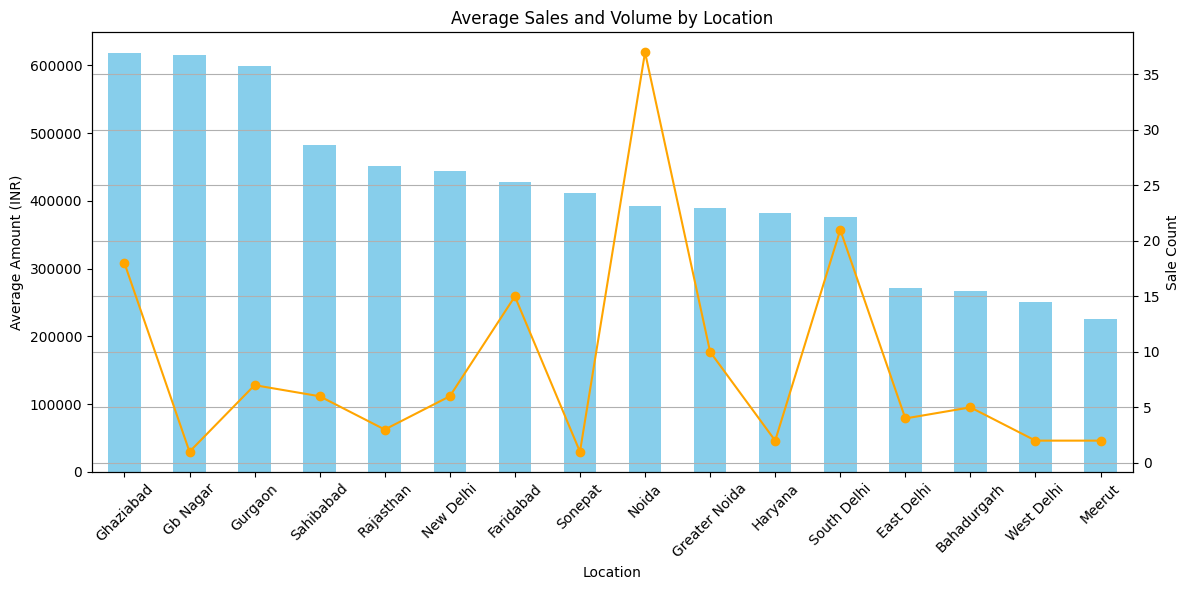

In [11]:
location_stats = df.groupby('Location').agg({'Amount': ['mean', 'count']})
location_stats.columns = ['Avg_Amount', 'Sale_Count']
location_stats = location_stats.sort_values(by='Avg_Amount', ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))
location_stats['Avg_Amount'].plot(kind='bar', color='skyblue', ax=ax1, label='Avg Amount')
ax1.set_ylabel('Average Amount (INR)')
ax1.set_title('Average Sales and Volume by Location')
ax1.set_xticklabels(location_stats.index, rotation=45)

# Plot count on secondary axis
ax2 = ax1.twinx()
ax2.plot(location_stats['Sale_Count'].values, color='orange', marker='o', label='Sale Count')
ax2.set_ylabel('Sale Count')

plt.grid(True)
plt.tight_layout()
plt.show()


This graph compares **average sales amount (₹)** with **sales volume** across various locations.

- **Top Performers by Value:** Ghaziabad, GB Nagar, and Gurgaon show the highest average sales, indicating premium market activity.
- **High Volume:** Noida leads in transaction count (~37), despite moderate sales value, suggesting strong market presence.
- **Mid-tier Locations:** Sahibabad, Faridabad, and New Delhi show moderate performance in both value and volume.
- **Low Performance:** Locations like Bahadurgarh and Meerut have both low value and volume.


### 5. Sale Amount Distribution by Success

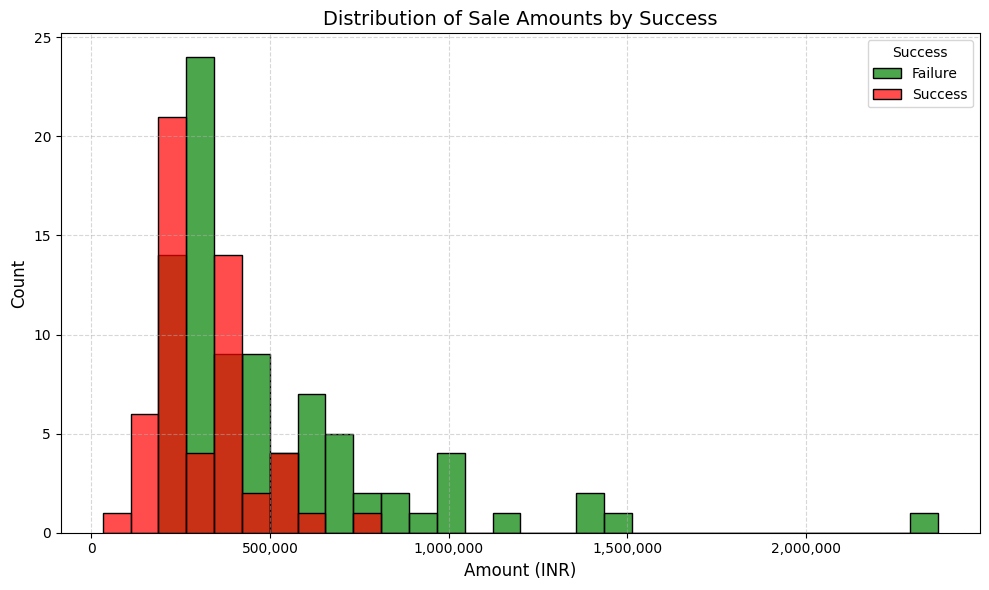

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Amount',
    hue='Success',
    bins=30,
    palette={0: 'red', 1: 'green'},
    alpha=0.7,
    edgecolor='black'
)

plt.title('Distribution of Sale Amounts by Success', fontsize=14)
plt.xlabel('Amount (INR)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Success', labels=['Failure', 'Success'])

# Format x-axis with comma-separated thousands
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The histogram reveals that successful sales tend to be distributed across a wide range of sale amounts, but are more frequent at moderate values. Many failed sales fall in the lower sale amount range, suggesting underpricing or low-value deals have lower success rates.

### 6. Sale Amount Distribution by Genset Rating

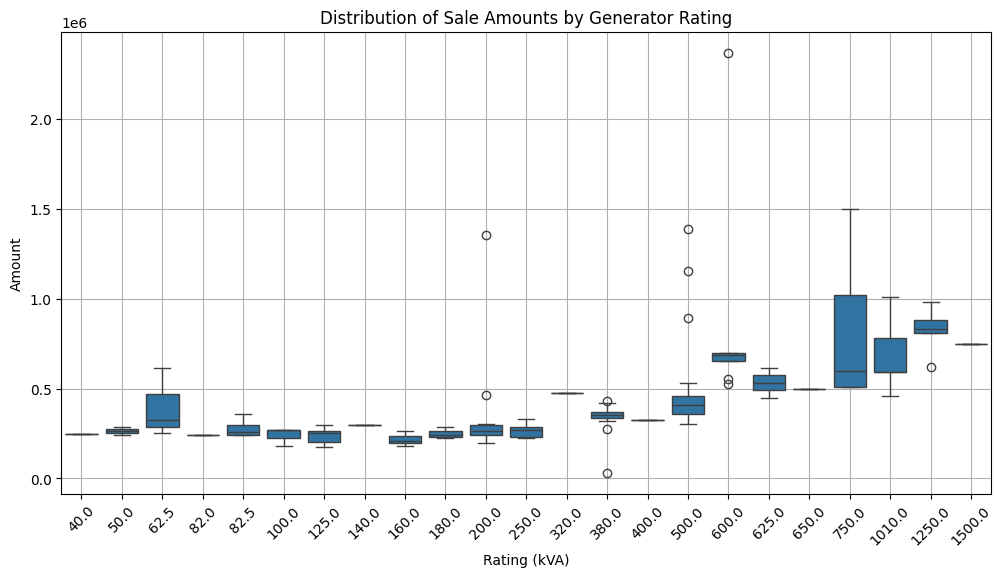

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rating_kVA', y='Amount', data=df)
plt.title('Distribution of Sale Amounts by Generator Rating')
plt.xlabel('Rating (kVA)')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Boxplots for each genset rating highlight how sale amounts vary with product size. Some high-rated gensets have extremely high sale amounts, indicating bulk or premium deals. Variability within each rating group is also notable, showing inconsistent pricing, possibly due to discounts or differing client types.

### 7. Success Rate by Salesman and Location Type

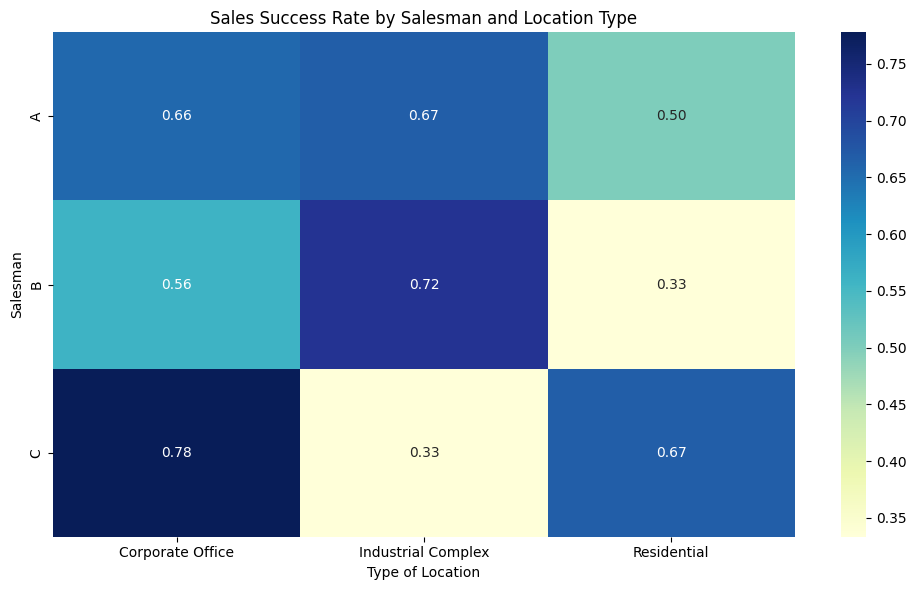

In [14]:
#Compute success rate per Salesman and Location Type
grouped_success = df.groupby(['Salesman', 'Type of Location'])['Success'].agg(['count', 'sum'])
grouped_success['Success Rate'] = grouped_success['sum'] / grouped_success['count']
grouped_success = grouped_success.reset_index()

pivot_table = grouped_success.pivot(
    index='Salesman',
    columns='Type of Location',
    values='Success Rate'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Sales Success Rate by Salesman and Location Type')
plt.xlabel('Type of Location')
plt.ylabel('Salesman')
plt.tight_layout()
plt.show()

This heatmap visualizes how effective each salesperson is across different location types. Salesman C performs best in Corporate Offices (78% success rate), whereas B is most effective in Industrial Complexes (72%). These insights suggest potential location-wise specialization or comfort zones for each salesperson, which could be leveraged for future territory planning.


# Data Modelling

In [15]:
# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

In [16]:
# Identify categorical and numerical features
cat_features = ['Type of Location', 'Location', 'Salesman', 'Type of Client']
num_features = ['Rating_kVA', 'Month', 'Rating_Avg_Amount', 'Amount_per_kVA', 'Location_Amount_Ratio']

In [17]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

In [18]:
# Prepare training and test data
X = df[cat_features + num_features]
y = df['Success']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
# Store results
results = []

for name, model in models.items():
    # Create pipeline for each model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for ROC AUC
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Cross-validation
    cv_score = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()
    
    results.append({
        'Model': name,
        'ROC-AUC (Test)': round(auc_score, 4),
        'Cross-Validation ROC-AUC': round(cv_score, 4)
    })

In [20]:
# Display all model results
results_df = pd.DataFrame(results).sort_values('Cross-Validation ROC-AUC', ascending=False)
print("\n Model Comparison Results:")
print(results_df.to_string(index=False))


 Model Comparison Results:
              Model  ROC-AUC (Test)  Cross-Validation ROC-AUC
Logistic Regression          0.8449                    0.7498
  Gradient Boosting          0.9519                    0.7415
      Random Forest          0.9037                    0.7142
K-Nearest Neighbors          0.6765                    0.4799


The table above summarizes the **ROC-AUC scores** of various classification models on both the test set and via cross-validation:

#### Key Observations

- **Gradient Boosting** achieved the highest test ROC-AUC (0.95), indicating strong performance on unseen data.
- **Random Forest** also performed well on the test set but had slightly lower cross-validation stability.
- **Logistic Regression** showed good balance between test and cross-validation performance, suggesting generalizable behavior.
- **K-Nearest Neighbors** underperformed on both metrics, likely due to sensitivity to feature scaling or noise.

#### Recommendation

Based on these scores, **Gradient Boosting** appears to be the best-performing model on the test set. However, **Logistic Regression** shows more consistent results across validation folds, making it a strong candidate depending on the use case and interpretability needs.
